#### In this script we run all the convergence scenarios, so 24 in total defned by the end year values and output the household disposable income gini coefficient. Then following this we translate this via a simple linear model determined in Oswald et al. 2020 https://www.nature.com/articles/s41560-020-0579-8 to final energy gini coefficients. 

In [1]:
# Import all things necessary
from scenario_class import Scenario
from plots_class import Plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import matplotlib.cm as cm
from scenariosweeper_class import ScenarioSweeper
import matplotlib.gridspec as gridspec
import pandas as pd
from tqdm import tqdm
import numpy as np

In [2]:
# calculate how much emissions are emitted in a given scenario run and how far above this is the carbon budget by summing the yearly emissions of all countries
# Example usage:
end_year_values = [2040, 2060, 2080, 2100]
income_goal_values = [5000, 10000, 15000, 20000, 25000, 30000]
carbon_budget_values = [1150*0.95 - 2*35] # 95% of the carbon budget because of 95% population coverage and minus two years because first model year is 2023 and the budgets are from 2020 onwards
#hysteresis_tech_progress_values = [0.01] # this is a growth rate, so between 0 and 1, which only applies if tech_hysteresis_assumption is on
gdp_assumption_values = ["constant_ratio"]
pop_growth_assumption_values = ["semi_log_model"]
tech_evolution_assumption_values = ["plausible"]
tech_hysteresis_assumption_values = ["off"]
steady_state_high_income_assumption_values = ["off"]
population_hysteresis_assumption_values = ["on"]
sigmoid_parameters = [0.05, 2060] # k, first param., is the steepness of the sigmoid (0 < k < 1) and t0, second param, is the year of the midpoint of the sigmoid function of the weighted
final_improvement_rate = -0.05 # final global uniform carbon intensity improvement rate that countries transition to from green growth trend which is the best rate that is currently grasped by the fit more or less
sweeper1 = ScenarioSweeper(end_year_values,
                           income_goal_values,
                           carbon_budget_values,
                           gdp_assumption_values,
                           pop_growth_assumption_values,
                           tech_evolution_assumption_values,
                           tech_hysteresis_assumption_values,
                           steady_state_high_income_assumption_values,
                           sigmoid_parameters,
                           final_improvement_rate,
                           population_hysteresis_assumption_values)


output = sweeper1.run_scenarios() 
# output[0] is the emissions and output[1] is the gdp growth rate globally
data = output[4] # output now will be transformed to an input for the plots function

c:\Users\yoswald\Dropbox\Arbeit\postdoc_lausanne\papers\convergence\scenario_class.py:478: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_df], ignore_index=True)
c:\Users\yoswald\Dropbox\Arbeit\postdoc_lausanne\papers\convergence\scenario_class.py:478: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_df], ignore_index=True)
c:\Users\yoswald\Dropbox\Arbeit\postdoc_lausanne\papers\convergence\scenario_class.py:478: FutureWarning: The behavior of DataFram

In [3]:
# Assuming 'data' is your dictionary with scenario dataframes
# Transform the data dictionary to a pandas dataframe
# Loop over the 24 scenarios in the data dictionary
# Initialize tqdm with the number of items
for index, (scenario, scenario_df) in enumerate(tqdm(data.items(), total=len(data), desc="Processing scenarios")):
    # Concatenate the dataframes of the different scenarios
    if index == 0:
        df = scenario_df
    else:
        df = pd.concat([df, scenario_df], ignore_index=True)

Processing scenarios:   0%|          | 0/24 [00:00<?, ?it/s]

Processing scenarios: 100%|██████████| 24/24 [00:00<00:00, 235.69it/s]


In [4]:
# add fifth column to df called energy_gini and fill with values based on the gini column values using the simple linear model energy_gini = 1.42*gini - 0.128
# if value is < 0, set value to 0 though
df["final_energy_gini"] = 1.42*df["gini"] - 0.128
df.loc[df["final_energy_gini"] < 0, "final_energy_gini"] = 0

# note the fit is the inverse of the fit in fig 2. oswald et al. 2020

In [5]:
# now save the df to a csv file
df.to_csv("output_energy_ginis_convergence_0_1.csv")

### Plot a few example countries across a few scenarios and their income and energy gini evolution

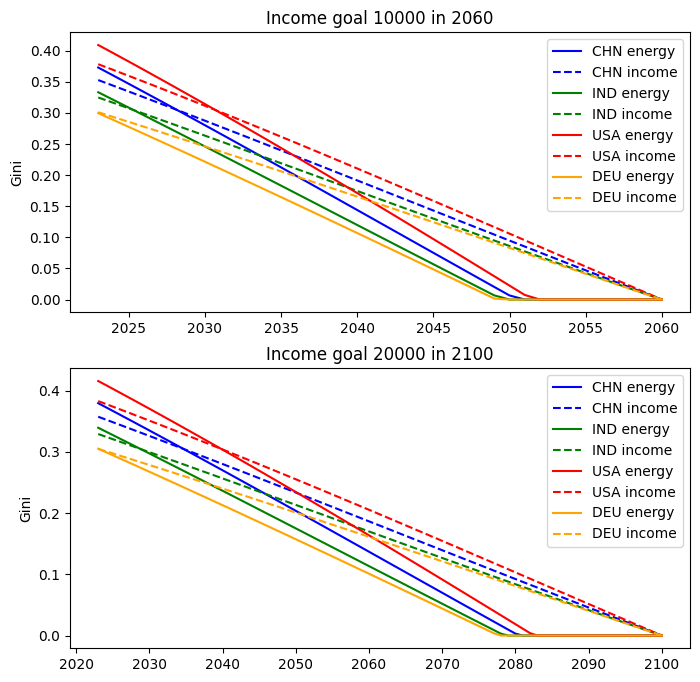

In [6]:
## subset the df scenarios only in the column scenario the values '10000_2060' and '20000_2100' and with respect to the column country 'CHN', 'IND', 'USA', 'DEU'
df_subset1 = df[(df["scenario"] == "10000_2060")]
df_subset1 = df_subset1[(df_subset1["country"] == "CHN") | (df_subset1["country"] == "IND") | (df_subset1["country"] == "USA") | (df_subset1["country"] == "DEU")] 

df_subset2 = df[(df["scenario"] == "20000_2100")]
df_subset2 = df_subset2[(df_subset2["country"] == "CHN") | (df_subset2["country"] == "IND") | (df_subset2["country"] == "USA") | (df_subset2["country"] == "DEU")]


# Define a color map for consistency
color_map = {
    "CHN": "blue",
    "IND": "green",
    "USA": "red",
    "DEU": "orange"
}


# plot the income and energy ginis for the two subsets with the country as the legend and the year as the x-axis
# also plot the gini for the two subsets with the country as the legend and the year as the x-axis for comparison in each panel with the lines dashed
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
for country in ["CHN", "IND", "USA", "DEU"]:
    df_subset1_country = df_subset1[df_subset1["country"] == country]
    df_subset2_country = df_subset2[df_subset2["country"] == country]
    ax[0].plot(df_subset1_country["year"], df_subset1_country["final_energy_gini"], label=country+' energy', color=color_map[country])
    ax[1].plot(df_subset2_country["year"], df_subset2_country["final_energy_gini"], label=country+' energy', color=color_map[country])
    ax[0].plot(df_subset1_country["year"], df_subset1_country["gini"], label=country+' income', linestyle="--", color=color_map[country])
    ax[1].plot(df_subset2_country["year"], df_subset2_country["gini"], label=country+' income', linestyle="--", color=color_map[country])
ax[0].set_title("Income goal 10000 in 2060")
ax[1].set_title("Income goal 20000 in 2100")
ax[0].set_ylabel("Gini")
ax[1].set_ylabel("Gini")
ax[0].legend()
ax[1].legend()
plt.show()



